## Get Best Feature Selection Counts/Method
---

In [3]:
import sys, os, json, copy, sklearn
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle as pkl
from tqdm import tqdm
from smart_open import open
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.insert(1, "../../..")
from src.feature_selection import (
    get_top_k_features,
    get_monotone_dir,
    remove_corr_fts
)
from rdsutils.metrics import (
    get_binary_metrics,
    get_pred_reports
)

plt.style.use("seaborn")
%load_ext autoreload
%autoreload 2

In [ ]:
segment = "full"

seed = 42
artifact_path = "s3://sofi-data-science/jxu/pl-gen4/prescreen"
data_dir = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen"
nr_to_consider = 150

with open(os.path.join(artifact_path, "config.json"), "r") as f:
    config = json.load(f)
    
with open(os.path.join(artifact_path, segment, "woe_dict.pkl"), "rb") as f:
    woe_dict = pkl.load(f)
    
with open(os.path.join(artifact_path, segment, "woe_json.json"), "r") as f:
    woe_json = json.load(f)
    
with open(os.path.join(artifact_path, segment, "monotone_dict.json"), "r") as f:
    monotone_dict = json.load(f)
    
display(config.keys()) 

# training data
target = "target"
target_indeterminate = "indeterminate"
ri_weight = "weight_ri"
weight = "weight"

In [ ]:
# get features
ranking = pd.read_csv(os.path.join(artifact_path, segment, "ranking.csv"), index_col=0)
features = ranking.index.to_list()
ranking.shape

In [ ]:
ranking.head()

In [5]:
# get all columns
seg_cols = ["applicant_vantage_score", "all_time_lending_member_flag"]

mrmr_shapcq_fts = get_top_k_features(ranking, "mrmr_shapcq_mc", nr_to_consider)
mrmr_shapcq_mc_xf = get_top_k_features(ranking, "mrmr_shapcq_mc_xf", nr_to_consider)
mrmr_ivcq_fts = get_top_k_features(ranking, "mrmr_ivcq", nr_to_consider)
shap_fts_full = get_top_k_features(ranking, "lgbm_shap_mc_full", nr_to_consider)
lgbm_shap_mc_full_r2 = get_top_k_features(ranking, "lgbm_shap_mc_full_r2", nr_to_consider)
shap_fts_top = get_top_k_features(ranking, "lgbm_shap_mc_top", nr_to_consider)

ft_lists = [("mrmr_shapcq", mrmr_shapcq_fts), 
            ("mrmr_shapcq_mc_xf", mrmr_shapcq_mc_xf),
            ("mrmr_ivcq", mrmr_ivcq_fts), 
            ("shap_fts_full", shap_fts_full),
            ("shap_fts_full_r2", lgbm_shap_mc_full_r2),
            ("shap_fts_top", shap_fts_top),
            ]


In [6]:
train_df = pd.read_parquet(config["data"]["prescreen-v2"][f"train_df_imputed"],
                    ) # columns=cols)
valid_df = pd.read_parquet(config["data"]["prescreen-v2"][f"valid_df_imputed"],
                    ) # columns=cols)
train_df.shape, valid_df.shape

((3277182, 436), (1101191, 436))

In [7]:
# check data is right
assert not train_df.isna().mean().any(), "still exiting missing values"
assert not valid_df.isna().mean().any(), "still exiting missing values"

display(train_df[target_indeterminate].value_counts())
display(valid_df[target_indeterminate].value_counts())

False    3277182
Name: indeterminate, dtype: int64

False    1092697
True        8494
Name: indeterminate, dtype: int64

In [8]:
#### corr threshold = 0.8

In [9]:
%%time
# lets first do not drop by corr
ct = 0.8
mrmr_shapcq_fts = remove_corr_fts(train_df, mrmr_shapcq_fts, weight, corr_threshold=ct)
mrmr_shapcq_mc_xf = remove_corr_fts(train_df, mrmr_shapcq_mc_xf, weight, corr_threshold=ct)
# mrmr_shapcxq_fts = remove_corr_fts(train_df, mrmr_shapcxq_fts, weight, corr_threshold=ct)
mrmr_ivcq_fts = remove_corr_fts(train_df, mrmr_ivcq_fts, weight, corr_threshold=ct)
shap_fts_full = remove_corr_fts(train_df, shap_fts_full, weight, corr_threshold=ct)
lgbm_shap_mc_full_r2 = remove_corr_fts(train_df, lgbm_shap_mc_full_r2, weight, corr_threshold=ct)
shap_fts_top = remove_corr_fts(train_df, shap_fts_top, weight, corr_threshold=ct)

len(mrmr_shapcq_fts), len(mrmr_shapcq_mc_xf), len(shap_fts_full), len(shap_fts_top)

CPU times: user 2h 13min 11s, sys: 10.5 s, total: 2h 13min 21s
Wall time: 2h 13min 21s


(114, 107, 105, 109)

In [10]:
(len(mrmr_shapcq_fts), len(mrmr_shapcq_mc_xf), 
len(shap_fts_full), len(shap_fts_top), 
len(mrmr_ivcq_fts), len(lgbm_shap_mc_full_r2))

(114, 107, 105, 109, 108, 101)

In [11]:
%%time

pred_cols = []
params = {}
n_features = [1, 2, 5, 10, 15, 
              20, 25, 30, 32, 
              35, 40, 50, 70, 100
             ]
algos = list(zip(*ft_lists))[0]

auc = pd.DataFrame(index = n_features, columns = algos)
ks = pd.DataFrame(index = n_features, columns = algos)
ap = pd.DataFrame(index = n_features, columns = algos)

df_ = train_df.groupby("target")["weight"].sum()
df_ = df_/df_.sum()
scale_pos_weight = 1/df_.loc[1.0]
scale_pos_weight = None

print("positive class weights: ", scale_pos_weight)

model_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting': 'gbdt',
    'max_depth': 6,
    'learning_rate': 0.05,
    'min_data_in_leaf': [300],
    'verbosity': -1,
    'seed': 42,
    'n_jobs': -1,
    'n_estimators': 1000,
    'scale_pos_weight': scale_pos_weight,
}
model_params["scale_pos_weight"] = None

for k in tqdm(n_features):
    for name, ftl in ft_lists:
        params_ = copy.deepcopy(model_params)
        fts = ftl[:k]
        mc = [monotone_dict[ft] for ft in fts]
        assert 0 not in mc
        params_["monotone_constraints"] = mc
        
        clf = lgb.LGBMClassifier(**params_)
        clf.fit(train_df[fts],
                train_df[target],
                sample_weight=train_df[weight])

        pred = clf.predict_proba(valid_df[fts])[:,1]
        pred_col = f"pred_{name}_{k}"
        
        train_df[pred_col] = clf.predict_proba(train_df[fts])[:,1]
        valid_df[pred_col] = clf.predict_proba(valid_df[fts])[:,1]

        pred_cols.append(pred_col)
        m = get_binary_metrics(valid_df[target], 
                               valid_df[pred_col], 
                               sample_weight=valid_df["weight_eval"])

        auc.loc[k, name] = m["auc"].item()
        ks.loc[k, name] = m["ks"].item()
        ap.loc[k, name] = m["ap"].item()

positive class weights:  None


  0%|          | 0/14 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

  7%|▋         | 1/14 [02:16<29:40, 136.98s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 14%|█▍        | 2/14 [04:29<26:53, 134.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 21%|██▏       | 3/14 [07:00<26:03, 142.16s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 29%|██▊       | 4/14 [09:50<25:30, 153.10s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 36%|███▌      | 5/14 [13:04<25:10, 167.87s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 43%|████▎     | 6/14 [16:36<24:21, 182.75s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 50%|█████     | 7/14 [20:56<24:16, 208.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 57%|█████▋    | 8/14 [25:03<22:01, 220.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 64%|██████▍   | 9/14 [29:08<19:00, 228.09s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 71%|███████▏  | 10/14 [33:43<16:09, 242.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 79%|███████▊  | 11/14 [38:33<12:51, 257.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 86%|████████▌ | 12/14 [44:18<09:27, 283.86s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

 93%|█████████▎| 13/14 [51:01<05:19, 319.96s/it]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 w

100%|██████████| 14/14 [59:26<00:00, 254.77s/it]

CPU times: user 2d 9h 8min 17s, sys: 11min 25s, total: 2d 9h 19min 42s
Wall time: 59min 26s


In [12]:
config["data"]["prescreen-v2"]

{'df': 's3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-v2/df.parquet',
 'train_df': 's3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-v2/train_df.parquet',
 'valid_df': 's3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-v2/valid_df.parquet',
 'test_df': 's3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-v2/test_df.parquet',
 'df_imputed': 's3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-v2/df_imputed.parquet',
 'train_df_imputed': 's3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-v2/train_df_imputed.parquet',
 'valid_df_imputed': 's3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-v2/valid_df_imputed.parquet',
 'test_df_imputed': 's3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-v2/test_df_imputed.parquet'}

In [13]:
fsel_results = valid_df[["id", "target", "weight_eval", "weight"]+pred_cols]
path = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen4-final-data/prescreen-v2/fsel_result_df.parquet"
config["data"]["prescreen-v2"]["fsel_result_df"] = path
fsel_results.to_parquet(path)

with open(os.path.join(artifact_path, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

In [14]:
valid_df.columns[valid_df.columns.str.contains("id")]

Index(['id'], dtype='object')

In [15]:
valid_df["pred_fico"] = -valid_df["applicant_fico_score"]
valid_df["pred_gen3"] = -valid_df["gen3_score"]  # reverse dir of gen3 score

pred_cols = list(set(pred_cols+["pred_gen3", "pred_fico"]))

metrics = get_pred_reports(valid_df, target, pred_cols, sample_weight_col="weight_eval")
metrics.sort_values("ks").head()

,auc,ap,ks
pred_shap_fts_full_1,0.596,0.2375,16.38
pred_mrmr_ivcq_1,0.596,0.2375,16.38
pred_mrmr_shapcq_mc_xf_1,0.596,0.2375,16.38
pred_shap_fts_top_1,0.596,0.2375,16.38
pred_shap_fts_full_r2_1,0.596,0.2375,16.38


In [17]:
local_artifact_path = "../../../artifacts/final_model/fsel"
os.makedirs(local_artifact_path, exist_ok=True)

fsel_results.to_parquet(os.path.join(local_artifact_path, "fsel_result.parquet"))
metrics.to_csv(os.path.join(local_artifact_path, "metrics.csv"))
auc.to_csv(os.path.join(local_artifact_path, "auc.csv"))
ks.to_csv(os.path.join(local_artifact_path, "ks.csv"))
ap.to_csv(os.path.join(local_artifact_path, "ap.csv"))

#### load things back

In [19]:
local_artifact_path = "../../../artifacts/final_model/fsel"
auc = pd.read_csv(os.path.join(local_artifact_path, "auc.csv"), index_col=0)
ks = pd.read_csv(os.path.join(local_artifact_path, "ks.csv"), index_col=0)
metrics = pd.read_csv(os.path.join(local_artifact_path, "metrics.csv"), index_col=0)

In [21]:
# algos = ('mrmr_shapcq',
#  'mrmr_shapcq_mc_xf',
#  'mrmr_ivcq',
#  'shap_fts_full',
#  'shap_fts_full_r2',
#  'shap_fts_top')


In [22]:
auc.tail()

,mrmr_shapcq,mrmr_shapcq_mc_xf,mrmr_ivcq,shap_fts_full,shap_fts_full_r2,shap_fts_top
35,0.7605,0.7586,0.7412,0.7618,0.7609,0.7587
40,0.7613,0.7606,0.7420,0.7628,0.7624,0.7608
50,0.7623,0.7640,0.7436,0.7644,0.7643,0.7639
70,0.7648,0.7668,0.7465,0.7661,0.7662,0.7669
100,0.7676,0.7685,0.7497,0.7683,0.7680,0.7680


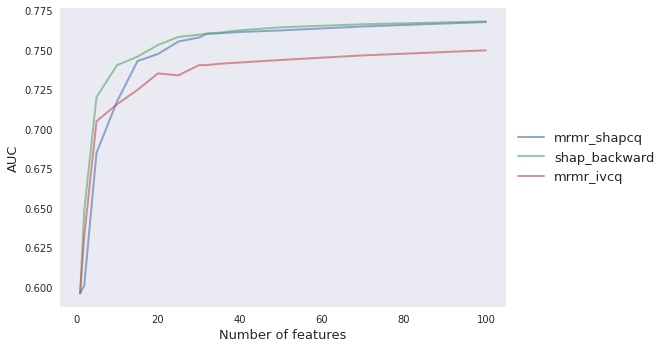

In [30]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(algos)]

algos = (
    'mrmr_shapcq',
    'shap_fts_full_r2',
    'mrmr_ivcq'
)
labels = (
    'mrmr_shapcq',
    'shap_backward',
    'mrmr_ivcq'
)
for algo, label, color in zip(
    algos,
    labels,
    colors):
        plt.plot(auc.index, auc[algo], label = label, 
                 color = color, lw=2, alpha=0.6)
# plt.plot(
#     [1, max(n_features)], [metrics.loc["pred_gen3"]["auc"]] * 2, 
#     label = 'gen3 pred', color = 'black', ls = '--',
# )
# plt.plot(
#     [1, max(n_features)], [metrics.loc["pred_fico"]["auc"]] * 2, 
#     label = 'fico pred', color = 'grey', ls = '--',
# )

plt.legend(fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid()
plt.xlabel('Number of features', fontsize = 13)
plt.ylabel('AUC', fontsize = 13)
plt.savefig(os.path.join(local_artifact_path))

Text(0, 0.5, 'KS')

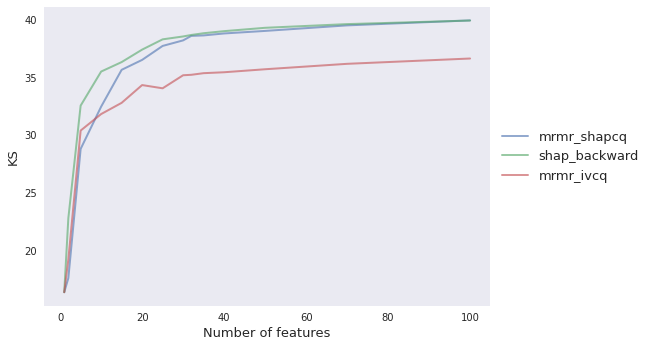

In [31]:
# algos = sorted(['mrmr_shapcq', 'shap_fts_full', 'shap_fts_top'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(algos)]

for algo, label, color in zip(
    algos,
    labels,
    colors):
        plt.plot(ks.index, ks[algo], label = label, 
                 color = color, lw=2, alpha=0.6)
# plt.plot(
#     [1, max(n_features)], [metrics.loc["pred_gen3"]["ks"]] * 2, 
#     label = 'gen3 pred', color = 'black', ls = '--',
# )
# plt.plot(
#     [1, max(n_features)], [metrics.loc["pred_fico"]["ks"]] * 2, 
#     label = 'fico pred', color = 'grey', ls = '--',
# )

plt.legend(fontsize = 13, loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.grid()
plt.xlabel('Number of features', fontsize = 13)
plt.ylabel('KS', fontsize = 13)

In [28]:
# cond = (metrics.index.str.endswith("_25") 
#         | metrics.index.str.endswith("_30") 
#         | metrics.index.str.endswith("_35") )
# metrics[cond].sort_values("ks")

In [32]:
pred_cols_ = metrics[cond].index.to_list()

In [ ]:
df_ = valid_df[valid_df.segmentation=="s1"]
metrics_s1 = get_pred_reports(df_, target, pred_cols_, sample_weight_col="weight_eval")
metrics_s1.sort_values("ks").tail()

In [ ]:
df_ = valid_df[valid_df.segmentation=="s2"]
metrics_s2 = get_pred_reports(df_, target, pred_cols_, sample_weight_col="weight_eval")
metrics_s2.sort_values("ks").tail()

In [ ]:
df_ = valid_df[valid_df.segmentation=="s3"]
metrics_s3 = get_pred_reports(df_, target, pred_cols_, sample_weight_col="weight_eval")
metrics_s3.sort_values("ks").tail()

### Get Feature types
---

In [ ]:
def get_feature_descriptions(features, data_dict):
    dd_cols = ["field_name", "description", "long description",
               "attr_grp", "categorical", "type", "tag"]
    dd = data_dict[dd_cols]
    dd = dd[dd.field_name.isin(features)]
            
    dd_fields = set(data_dict.field_name.unique())
    dd.set_index("field_name", inplace=True)

    bureau_fts = [f for f in features if f in dd_fields]
    bureau_dd = dd.loc[bureau_fts]
    bureau_dd["src"] = "bureau"
    bureau_dd["prefix"] = [ft.split("_")[1][:-4] for ft in dd.index]
    
    if len(features) == len(bureau_fts):
        return bureau_dd
    
    custom_ft = [f for f in features if f not in dd_fields]
    custom_dd = pd.DataFrame(index=custom_ft)
    custom_dd["src"] = "custom"
    custom_dd["prefix"] = "custom"
    return pd.concat([bureau_dd, custom_dd]).loc[features]

dd_path = 's3://sofi-data-science/hpeng/pl-gen4/data_dump/data_dict/combined_dict.csv'
exp_ddict_updated = pd.read_csv(dd_path, index_col=0)

In [ ]:
ft_dicts = {}
for fname, flist in ft_lists:
    ft_dicts[fname] = get_feature_descriptions(flist, exp_ddict_updated)

### Plot Risk Plots for all the features and select good ones
---

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")


def get_risk_plot(df, label, pred, features, equal_width=False, ncols=6, figsize=None, weight=None, **kwargs):
    """
    Build the risk sensitivity plot for a set of models and features.
    """
    nrows = int(np.ceil(len(features) / ncols))
    if weight is None:
        df[weight] = 1

    if figsize is None:
        figsize = (ncols * 8, nrows * 8)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for f, ax in zip(features, axs.flatten()):
        res = df.rename(columns={label:'actual', pred:'pred'})
        if res[f].nunique()>10:
            res = res[(res[f] < res[f].quantile(0.99)) & (res[f] > res[f].quantile(0.01))]
            if equal_width:
                res = res.groupby(pd.cut(res[f], 10, duplicates='drop')).apply(lambda x: pd.Series(np.average(x[['actual', 'pred']], weights = x[weight], axis=0), ['actual', 'pred'])).reset_index()
            else:
                res = res.groupby(pd.qcut(res[f], 10, duplicates='drop')).apply(lambda x: pd.Series(np.average(x[['actual', 'pred']], weights = x[weight], axis=0), ['actual', 'pred'])).reset_index()
            res[f] = res[f].apply(lambda x: '({:.3f},{:.3f}]'.format(x.left, x.right) if x.right <= 1 
                                   else '({:.0f},{:.0f}]'.format(x.left, x.right))
        else:
            res = res.groupby(f).apply(lambda x: pd.Series(np.average(x[['actual', 'pred']], weights = x[weight], axis=0), ['actual', 'pred'])).sort_values(by='actual').reset_index()
            
        res = pd.melt(res, id_vars=f, value_vars=['actual','pred'], value_name=label)
        sns.lineplot(x=f, y=label, ax=ax, hue='variable', data=res, palette='Blues_r', ci=95)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    #     plt.title('Prediction vs Actual by {}'.format(f))
        ax.tick_params(axis='x', labelrotation=45)
        sns.despine()
    plt.tight_layout()
    plt.show()

In [ ]:
# np.mean(valid_df[['target', pred_col]], axis=0)
# np.average(valid_df[['target', pred_col]], weights = valid_df["weight_eval"], axis=0)
valid_df.groupby("ri_source")["weight_eval"].sum().round()

ri_source
booked     68466.0
others    444669.0
proxy      99184.0
Name: weight_eval, dtype: float64

In [ ]:
valid_df.groupby("ri_source")["target"].mean().round(4)

ri_source
booked    0.0600
others    0.4999
proxy     0.1186
Name: target, dtype: float64

<AxesSubplot:>

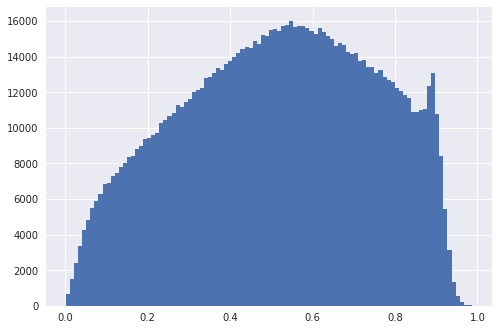

In [ ]:
models = {}
for mname, mpath in config["models"]["prescreen"].items():
    with open(mpath, "rb") as f:
        model = pkl.load(f)
        models[mname] = model
#         features += model.feature_name_

lgbm_bmk = models["lgbm_bmk_imputed"]

valid_df["pred_bmk"] = lgbm_bmk.predict_proba(valid_df[lgbm_bmk.feature_name_])[:,1]
valid_df["pred_bmk"].hist(bins=100)

No handles with labels found to put in legend.


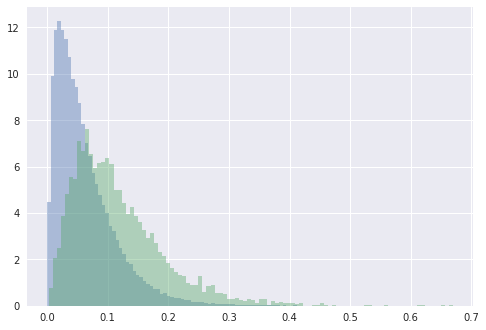

In [ ]:
valid_df[valid_df.ri_source=="booked"].groupby("target")[pred_col].hist(bins=100, alpha=0.4, density=True)
plt.legend()
plt.show()

<AxesSubplot:>

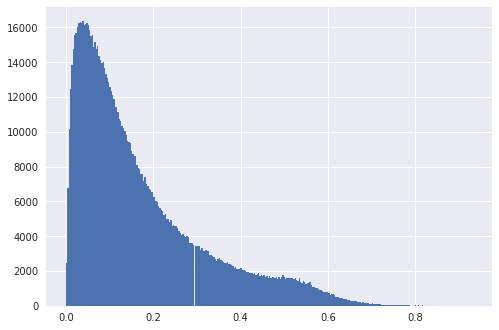

In [ ]:
valid_df[pred_col].hist(bins=300)

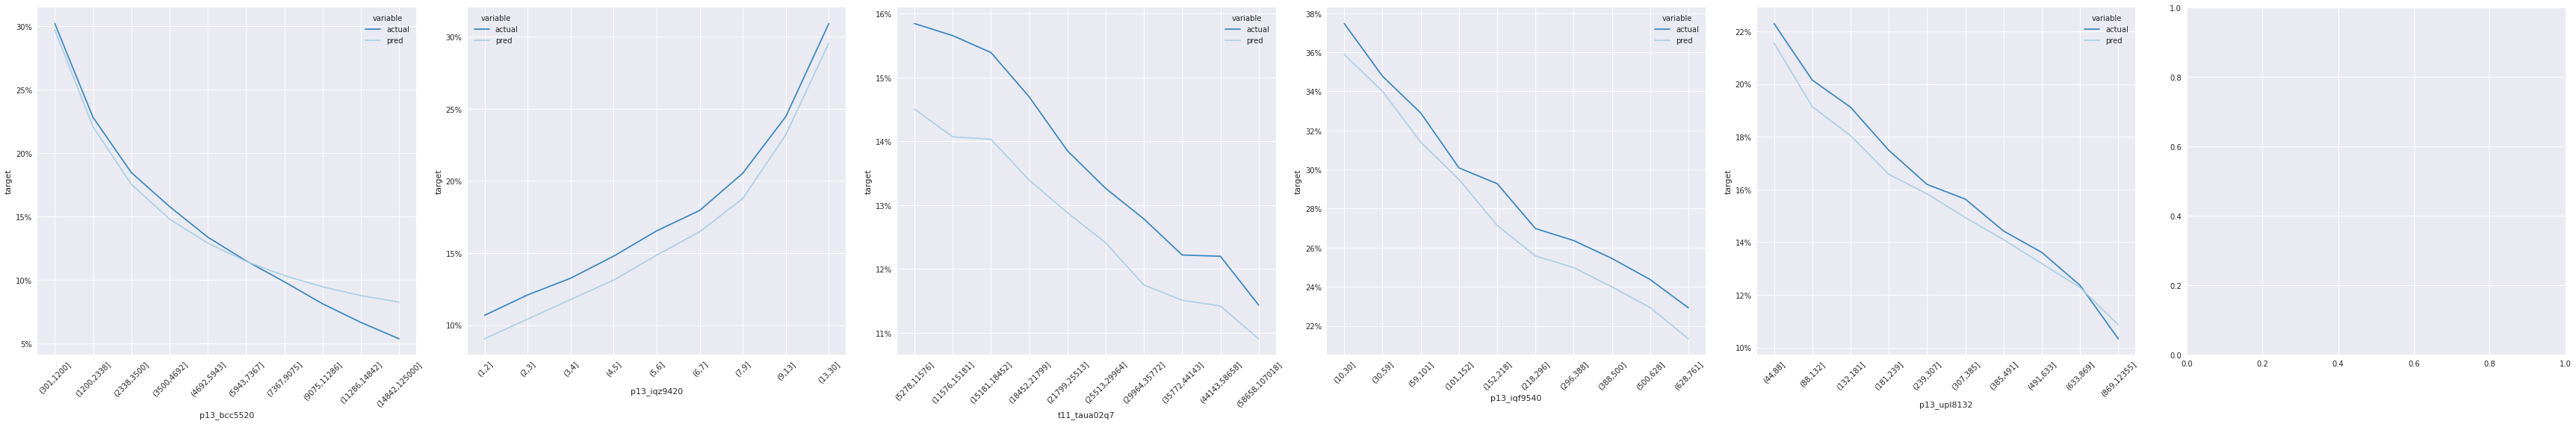

CPU times: user 11.5 s, sys: 5.86 s, total: 17.4 s
Wall time: 16.9 s


In [ ]:
%%time

n_fts = 5
pred_col = f"pred_shap_fts_full_{n_fts}"
get_risk_plot(valid_df, label="target", pred=pred_col, equal_width=False,
              features=shap_fts_full[:n_fts], weight="weight_eval")

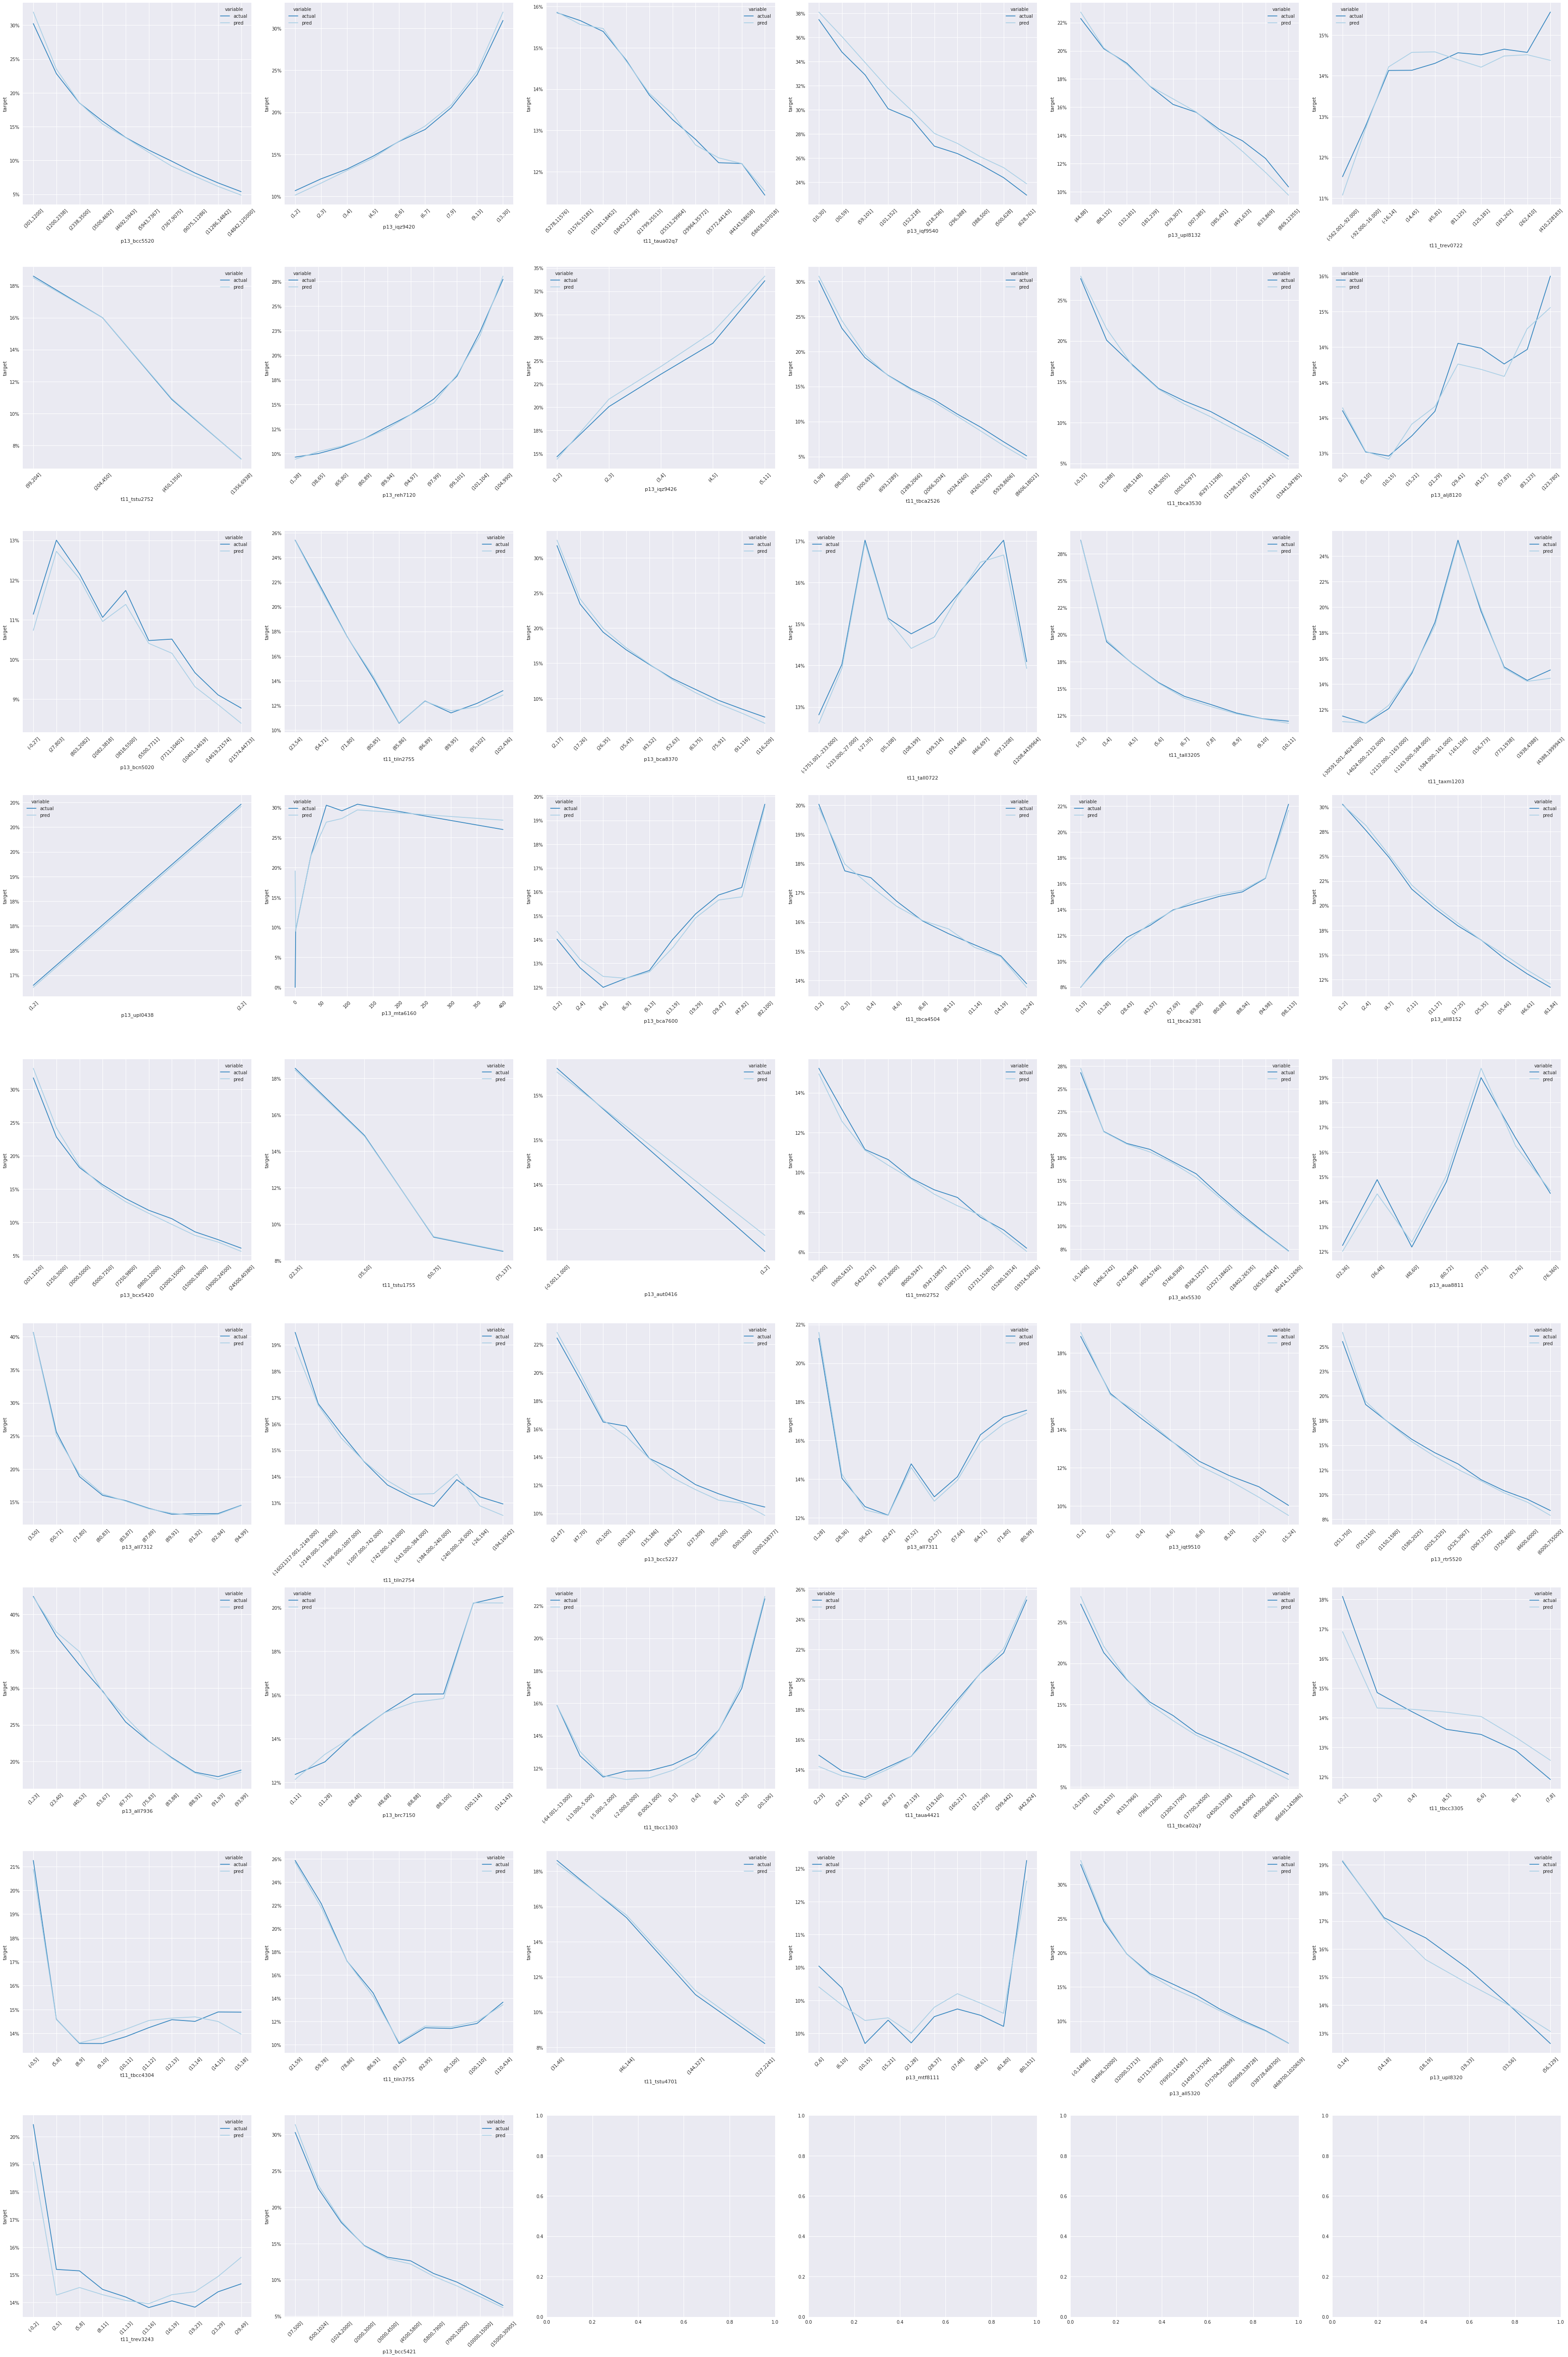

CPU times: user 2min 11s, sys: 1min 7s, total: 3min 19s
Wall time: 3min 18s


In [ ]:
%%time

n_fts = 50
pred_col = f"pred_shap_fts_full_{n_fts}"
get_risk_plot(valid_df, label="target", pred=pred_col,
              features=shap_fts_full[:n_fts], weight="weight_eval")